In [1]:
from __future__ import division, print_function, absolute_import

import sqlite3
import tflearn as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('surge_data.db')
c = conn.cursor()

point_list = [0, 1, 2, 3, 14, 15, 16, 12, 13, 24, 25, 26, 27, 28, 17, 29]

sql_output = np.array([np.array(pd.read_sql('''WITH a AS (SELECT surge
                                               FROM surge
                                               WHERE point = {} 
                                               ORDER BY date
                                               LIMIT 31184)
                                               SELECT *
                                               FROM a'''.format(point), conn)).T for point in point_list])[:,0,:].T

# this gets run when I'm done working for the session
conn.close()

In [3]:
steps_of_history = 30
steps_in_future = 5

y = sql_output[steps_of_history+steps_in_future-1:,:]
X = sql_output[:len(y),:]
my_x = np.empty([len(y),steps_of_history,16])

for i, _ in enumerate(X):
    time_chunk = X[i:i+steps_of_history,:]
    if time_chunk.shape == (steps_of_history, 16):
        my_x[i,:,:] = time_chunk
    else:
        my_x[i,:,:] = np.ones((steps_of_history,16))

trainX, testX = my_x[:-1000,:], my_x[-1000:,:]
trainY, testY = y[:-1000,:], y[-1000:,:]

In [4]:
# Build my neural net
net = tf.input_data(shape=[None, steps_of_history, 16])
net = tf.lstm(net, n_units=128, activation='softsign', return_seq=False)
net = tf.fully_connected(net, 16, activation='linear')
net = tf.regression(net, optimizer='sgd', loss='mean_square', learning_rate=0.3)

# Define model
model = tf.DNN(net, clip_gradients=0.0, tensorboard_verbose=0)

In [5]:
# Training
# model.fit(trainX, trainY, n_epoch=25, validation_set=0.1, batch_size=128)

In [6]:
# Manually save model
# model.save("saved_model/150_epoch_act_softsign_nunits_128.tfl")

In [7]:
# Load a model
model.load("saved_model/150_epoch_act_softsign_nunits_128.tfl")

In [8]:
predictY = np.array(model.predict(testX))

In [9]:
# when the model forecasts that the surge will be LESS than 1 I correct it to say it is 1
corrected_predictions = np.zeros(predictY.shape)

for i, time in enumerate(predictY):
    for j, point in enumerate(time):
        if point <=1.04:
            corrected_predictions[i,j] = 1.0
        else:
            corrected_predictions[i,j] = point

In [10]:
np.mean((predictY - testY)**2), np.mean((corrected_predictions - testY)**2)

(0.029269781018171962, 0.029113262822783818)

In [11]:
predictY = corrected_predictions

In [12]:
def graph_em(test, forecast, graph_name):
    subs = {0:811, 1:812, 2:813, 3:814, 4:815, 5:816, 6:817, 7:818}
    plt.figure(figsize=(20,25))
    for i, point in enumerate(test.T):
        plt.subplot(subs[i])
        plt.title('History='+str(steps_of_history)+', Future='+str(steps_in_future))
        plt.plot(point, 'k-', label='Actual')
        plt.plot(forecast[:,i], 'c-', label='Forecast')
        plt.legend()
        
#     plt.savefig(graph_name, bbox_inches='tight', dpi=300)
    plt.show()

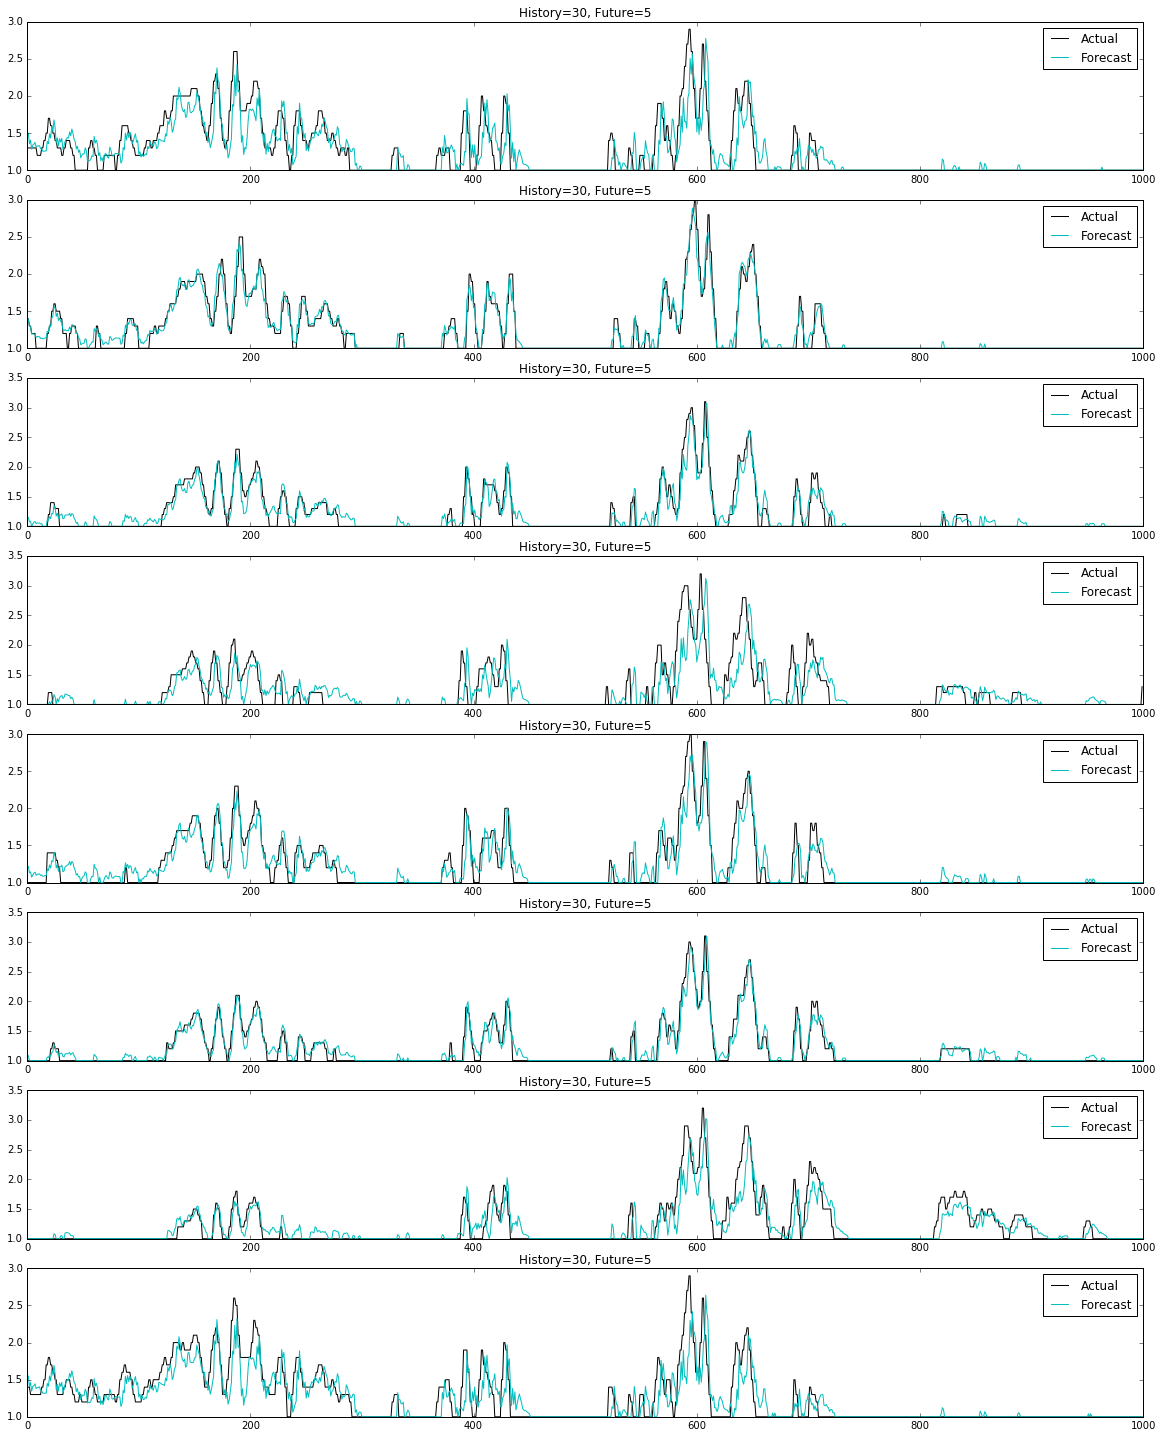

In [13]:
graph_em(testY[:,:8], predictY[:,:8], 'forecast_1.png')

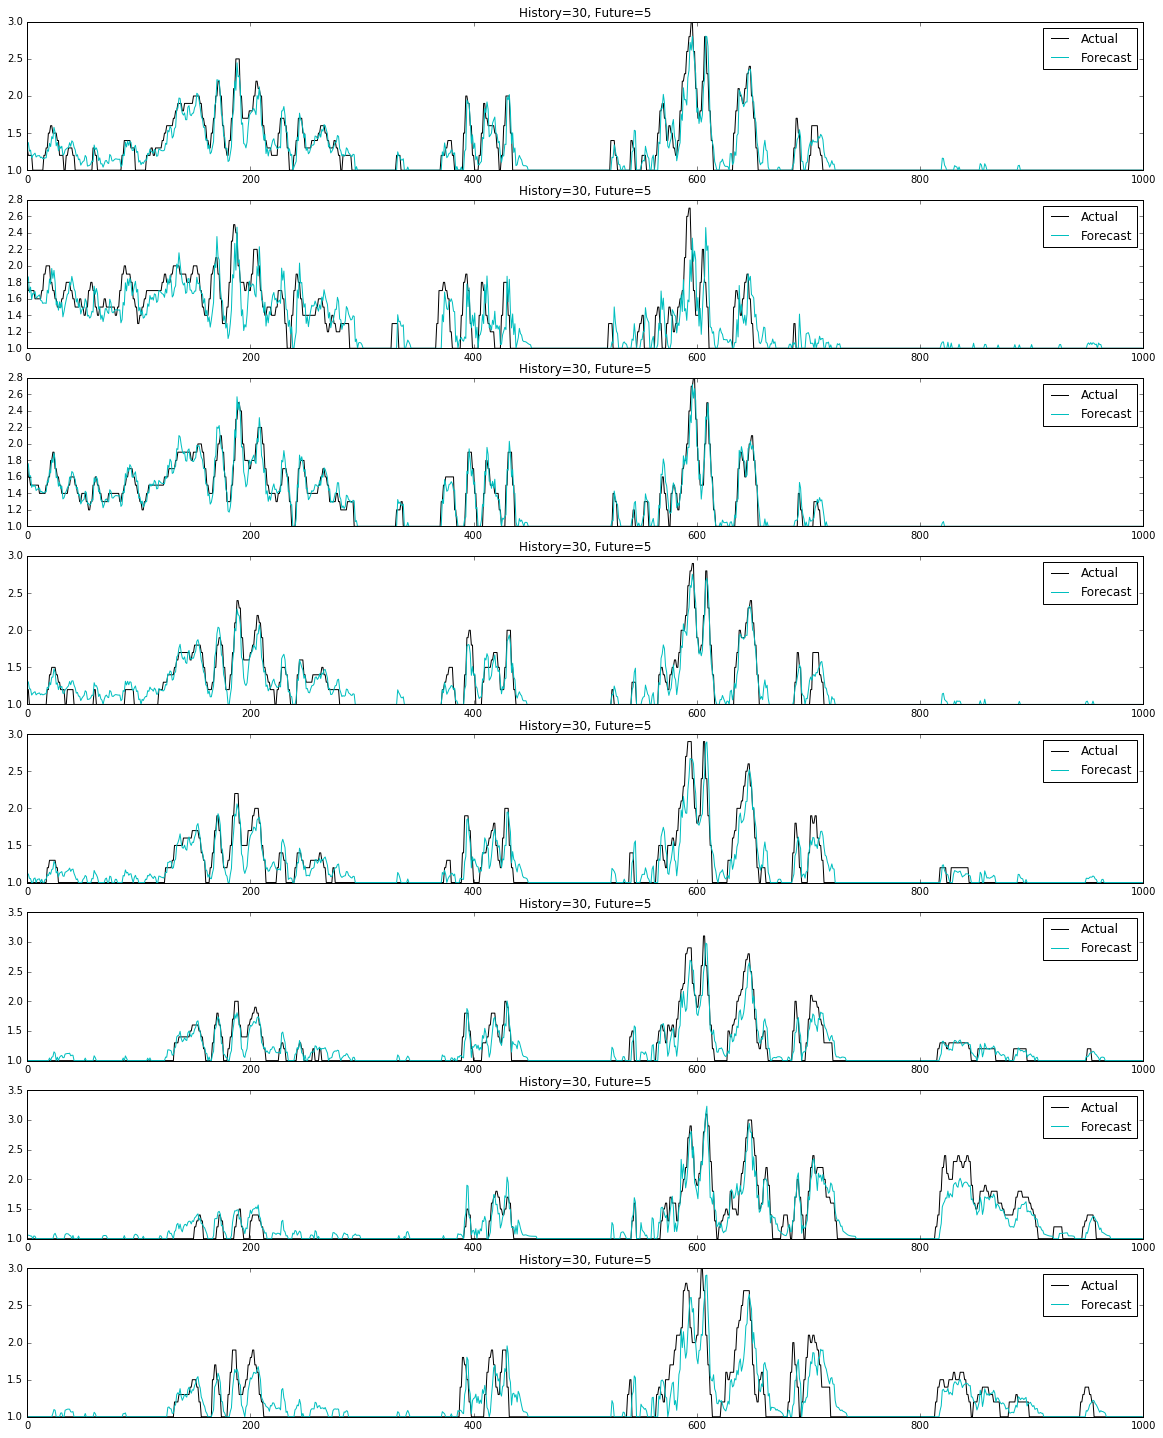

In [14]:
graph_em(testY[:,8:], predictY[:,8:], 'forecast_2.png')